### Import needed libraries

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images


In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
train_tranforms = transforms.Compose([
    transforms.ToTensor(),                     # Convert numpy array to tensor
    transforms.Normalize(0.49, 0.248),         # Use mean and std from preprocessing notebook
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),   # Data Augmentation
    transforms.RandomResizedCrop((224,224), scale=(0.5,1))    #RandomResizedCrops which applies a random crop of the 
])                                                            #image and resizes it to the original image size (224x224)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248)
])

In [4]:
train_data = torchvision.datasets.DatasetFolder("Processed/train", loader=load_file,
                                                extensions="npy", transform=train_tranforms)
val_data = torchvision.datasets.DatasetFolder("Processed/val", loader=load_file,
                                             extensions="npy", transform=val_transform)

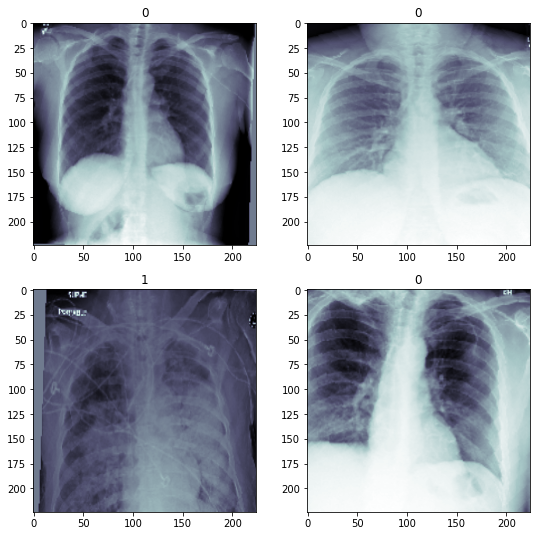

In [5]:
fig, axis = plt.subplots(2,2, figsize=(9,9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,24000)
        x_ray, label = train_data[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(label)

In [6]:
batch_size = 128
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
print(f"There are {len(train_data)} train images and {len(val_data)} val images")

There are 24000 train images and 2684 val images


In [8]:
np.unique(train_data.targets, return_counts=True)

(array([0, 1]), array([18593,  5407], dtype=int64))

In [9]:
np.unique(val_data.targets, return_counts=True)

(array([0, 1]), array([2079,  605], dtype=int64))

The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia. There are multiple ways to deal with imbalanced datasets:

* Weighted Loss
* Oversampling
* Doing nothing

In this example, we will simply do nothing as this often yields the best results. Buf feel free to play around with a weighted loss.

In [10]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()   # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]   # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)   # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()   # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]   # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)   # Compute the loss
        
        # Log validation metrics
        self.log("Validation Loss", loss)
        self.log("Step Validation ACC", self.val_acc(torch.sigmoid(pred), label.int()))
    
    def validation_epoch_end(self, outs):
        self.log("Validation ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [12]:
model = PneumoniaModel()

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [13]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor="Val Acc", save_top_k=10, mode="max")

In [14]:
#gpus = 1
#trainer = pl.Trainer(gpus=gpus, logger= TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
 #                    callbacks=checkpoint_callback, max_epochs=35)
trainer = pl.Trainer(logger= TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback, max_epochs=35)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss      | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")